## 2.1 Compute 'Irregular Shape' Object Orientation using PCA Algorithm

- <font color="orange">Principal Component Analysis (PCA)</font> is a technique used to <font color="orange">simplify complex data</font> by finding the most <font color="orange">important patterns</font> in it.<br>
<img src="resource/pca_ilus_2.png" width="60%"><br><br>
    - Above data has two variables: `y` and `x`. 
    - However, these two variables are <font color="orange">not independent</font> of each other. 
        - higher `x` has higher `y`
        - lower `x` has lower `y`
        - given the `x`, we can probably estimate the `y`; and vice versa.
    - That's mean they have a <font color="orange">strong correlation</font>. 
    - Thus, we may say that the `x` & `y` can be described with a <font color="orange">single component</font>.

- Ilustration how to compute PCA<br><br>
<img src="resource/pca_ilus_3.png" width="80%"><br><br>
- The <font color="orange">eigenvector</font> with the highest <font color="orange">eigenvalue</font> is the <font color="orange">first principal component</font>—the best direction for data variation.
<img src="resource/pca_animate.gif" width="60%"><br><br>

- Compute PCA in OpenCV<br>
    ```python
    cv2.PCACompute(data)
- Input : 
    - `data` (`numpy.ndarray`)
        - A 2D array of shape (`N`, `D`), where:
        - `N` = Number of data points (e.g., contour points)
        - `D` = Number of features (e.g., 2 for (x, y) coordinates)
- Output :
    - `mean` (`numpy.ndarray`)
        - A (1, `D`) array representing the mean of the data.
    - `eigenvectors` (`numpy.ndarray`)
        - A (`D`, `D'`) array where each row is an eigenvector.
        - The `first eigenvector` corresponds to the `principal axis` (largest variance direction).
        - `D'` is the number of selected components (default is D).

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV version: " + cv2.__version__)

#### EXAMPLE 1 - Find Object Orientation using PCA

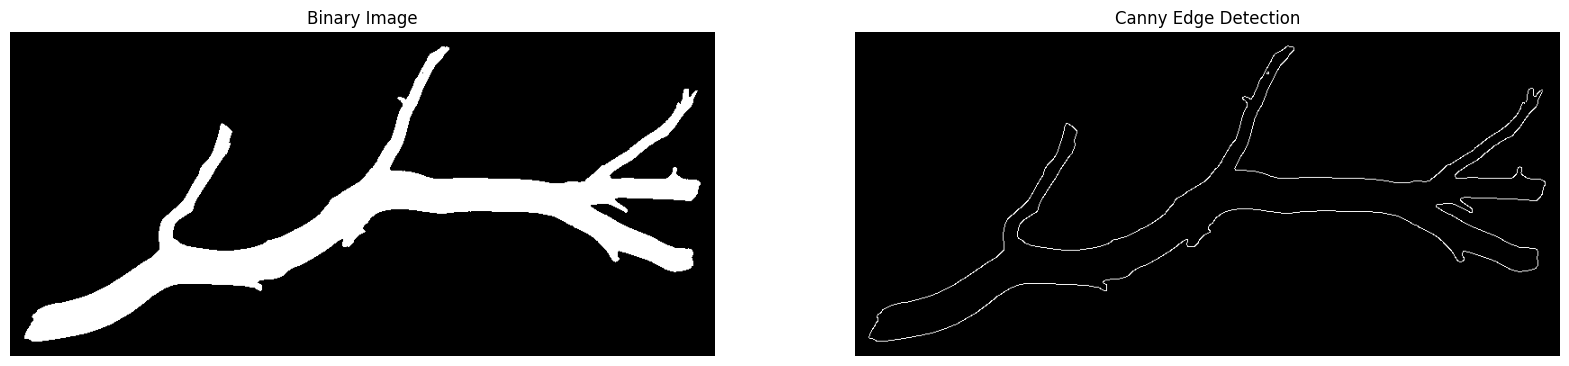

In [18]:
# Load and convert the image to grayscale
image = cv2.imread("branch.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: Apply simple Binary Thresholding (Inverse Binary Thresholding)
_, binary = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)

# Step 2: Apply Canny Edge Detection
edges = cv2.Canny(binary, 50, 200)

# Display the images binary and edges
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(binary, cmap="gray")
plt.title("Binary Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")

plt.show()

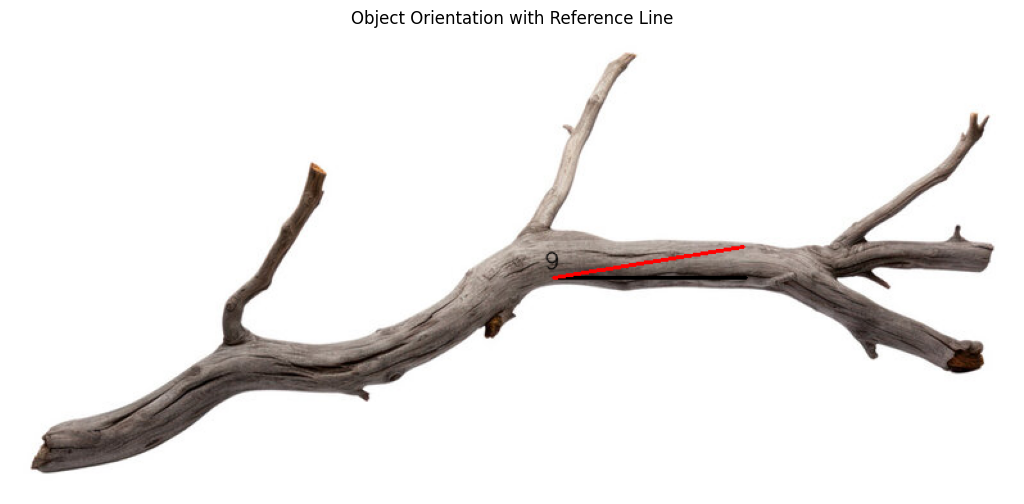

In [30]:
# Step 3: Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Calculate minimum area bounding rectangle
output = image.copy()
for contour in contours:
    
    # filter out small contours
    if len(contour) <= 5 or cv2.contourArea(contour) < 50:
        continue

    # calculate PCA of the contour
    data_points = np.array(contour.squeeze(), dtype=np.float64)
    mean, eigenvectors = cv2.PCACompute(data_points, mean=None)

    # calculate the center of the contour
    center = tuple(mean[0].astype(int))

    # eigenvectors[0, 0] is the x-component of the first eigenvector
    # eigenvectors[0, 1] is the y-component of the first eigenvector
    # Computes the angle (θ) of the principal axis with respect to the x-axis.
    angle_rad = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0]) # in radians within the range [-π, π]
    angle = abs(np.rad2deg(angle_rad)) # in degrees within the range [0, 180]

    # Define the length of the orientation lines
    length = 150

    # Black line for original orientation, always referenced as horizontal line
    cv2.line(output, center, (center[0] + length, center[1]), (0, 0, 0), 2)  

    # Compute the end point for the **rotation axis** (red line)
    end_x = int(center[0] + length * eigenvectors[0, 0]) 
    end_y = int(center[1] + length * eigenvectors[0, 1]) 
    cv2.line(output, center, (end_x, end_y), (0, 0, 255), 2)  # Red line for rotation axis

    # Draw angle text near the red line
    text_position = (center[0] - 7, center[1] - 7)
    cv2.putText(output, f"{int(angle)}", text_position, cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (0, 0, 0), 1, cv2.LINE_AA)

                    
# Show results using Matplotlib
plt.figure(figsize=(20, 6))
plt.imshow(output[:, :, ::-1])  # Convert BGR to RGB
plt.axis("off")
plt.title("Object Orientation with Reference Line")
plt.show()

## Source : 
- https://devopedia.org/principal-component-analysis
- https://builtin.com/data-science/step-step-explanation-principal-component-analysis